# Multivariate Multi-Step CNN Models
ref: https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/ section "Multivariate Multi-Step CNN Models"

In [1]:
from data_loader import load_names_from_web, holdout_split

In [3]:
import numpy as np
from numpy import array
from numpy import hstack

import pandas as pd

from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Flatten, Conv1D, MaxPooling1D, Input
from keras.optimizers import Adam
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


## load and format data

In [4]:
dfraw = load_names_from_web(category="national", hide_pre_1937=True, use_existing_files=True)
dfraw.sample(5)

,state,year,name,M/F,count
997980,US,1988,Daunte,M,23
1271320,US,1993,Friedrich,M,10
512156,US,2005,Daemian,M,7
1985095,US,2018,Khairi,M,22
840531,US,1959,Candee,F,33


In [5]:
df1 = dfraw.copy()
df1['name_g'] = df1['name'] + '_' + df1['M/F']
df1.drop(columns=['state', 'name', 'M/F'], inplace=True)
df1.head()

,year,count,name_g
0,2000,25957,Emily_F
1,2000,23085,Hannah_F
2,2000,19968,Madison_F
3,2000,17998,Ashley_F
4,2000,17712,Sarah_F


In [6]:
# for now, lets just look at names that have been used continuously throughout the years.
# for later iterations, can replace this cell with another cell creating df2
unique_years = df1['year'].nunique()
complete_records = df1.groupby('name_g').filter(lambda x: x['year'].nunique() == unique_years)
df2 = complete_records.reset_index(drop=True)
print(df2.shape, 'names: ', df2['name_g'].nunique())
df2.head()

(202702, 3) names:  2357


,year,count,name_g
0,2000,25957,Emily_F
1,2000,23085,Hannah_F
2,2000,17712,Sarah_F
3,2000,17265,Samantha_F
4,2000,15711,Jessica_F


In [7]:
# reformat the dataframe with a column for each name
df3 = df2.pivot(index='year', columns='name_g', values='count')
print(df3.shape)
df3.head()

(86, 2357)


name_g,Aaron_M,Abbie_F,Abby_F,Abe_M,Abel_M,Abelardo_M,Abigail_F,Abner_M,Abraham_M,Abram_M,...,Zack_M,Zana_F,Zane_M,Zeb_M,Zelda_F,Zena_F,Zenobia_F,Zina_F,Zoe_F,Zulema_F
year,,,,,,,,,,,,,,,,,,,,,
1937,465,52,25,63,91,25,45,39,217,31,...,32,15,49,17,147,16,33,12,72,8
1938,477,56,21,55,87,28,50,49,212,37,...,31,15,62,15,145,16,36,11,65,17
1939,471,70,24,56,95,31,53,34,197,31,...,33,8,61,12,127,13,47,15,55,19
1940,514,57,37,54,101,33,48,34,219,23,...,18,18,68,16,128,19,35,13,54,18
1941,562,50,32,66,121,17,40,38,194,29,...,30,10,52,11,106,21,25,14,60,21


In [8]:
# make the df into an array
df3array = df3.to_numpy()
print(np.shape(df3array))
df3array[:2,:2]

(86, 2357)


array([[465,  52],
       [477,  56]])

## split training and test

In [9]:
num_years_to_predict = 2

In [10]:
# look at the end of dataframe, so I can make sure my numpy arrays are correct
df3.tail(num_years_to_predict+2)

name_g,Aaron_M,Abbie_F,Abby_F,Abe_M,Abel_M,Abelardo_M,Abigail_F,Abner_M,Abraham_M,Abram_M,...,Zack_M,Zana_F,Zane_M,Zeb_M,Zelda_F,Zena_F,Zenobia_F,Zina_F,Zoe_F,Zulema_F
year,,,,,,,,,,,,,,,,,,,,,
2019,5534,91,623,81,2463,65,9171,182,2061,609,...,130,28,1596,10,436,90,37,56,5067,55
2020,5087,88,595,53,2124,62,7891,219,1897,509,...,138,20,1354,14,524,83,46,27,4791,85
2021,4843,98,523,64,1944,48,6969,213,1908,477,...,150,14,1484,17,491,83,32,22,4724,103
2022,4496,81,508,58,1753,53,6254,190,1824,429,...,142,27,1338,18,434,90,32,38,4984,75


In [11]:
# create train. show last two rows
train = df3array[:-num_years_to_predict,:]
print(train.shape)
train[-2:,:]

(84, 2357)


array([[5534,   91,  623, ...,   56, 5067,   55],
       [5087,   88,  595, ...,   27, 4791,   85]])

In [12]:
# create test. Show it
test = df3array[-num_years_to_predict:,:]
print(test.shape)
test

(2, 2357)


array([[4843,   98,  523, ...,   22, 4724,  103],
       [4496,   81,  508, ...,   38, 4984,   75]])

## model 1

In [13]:
n_steps_in = 10
n_steps_out = num_years_to_predict

In [14]:
# function to split a multivariate sequence into samples
def split_sequences1(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


In [15]:
X2, y2 = split_sequences1(train, n_steps_in, n_steps_out)
print('shapes', X2.shape, y2.shape)

n_output = y2.shape[1] * y2.shape[2]
y3 = y2.reshape((y2.shape[0], n_output))
n_features = X2.shape[2]

shapes (73, 10, 2357) (73, 2, 2357)


In [16]:
# define model
model = Sequential()
model.add(Input(shape=(n_steps_in, n_features)))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(n_output))
model.compile(optimizer='adam', loss='mse')

In [17]:
# this might be slow. For 10 in, 2 out, this took less than 3 minutes on laptop



# fit model
model.fit(X2, y3, epochs=7000, verbose=0)

## predict 1

In [18]:
x_input = train[-n_steps_in:, :]
print(x_input.shape)
x_input = x_input.reshape((1, n_steps_in, n_features))
x_input

(10, 2357)


array([[[7619,  340, 1065, ...,   29, 6307,   39],
        [7538,  343, 1037, ...,   25, 6464,   40],
        [7315,  245,  907, ...,   25, 5974,   31],
        ...,
        [5986,  120,  655, ...,   49, 5121,   50],
        [5534,   91,  623, ...,   56, 5067,   55],
        [5087,   88,  595, ...,   27, 4791,   85]]])

In [19]:
yhat = model.predict(x_input, verbose=0)
print(yhat.shape)

(1, 4714)


In [20]:
yhat2 = yhat.reshape(num_years_to_predict,n_features) #num years to predict, width of (train) array

In [21]:
yhat2

array([[5184.4165  ,   57.99264 ,  546.8486  , ...,   30.704067,
        4202.45    ,   23.382248],
       [4414.643   ,   66.03787 ,  556.4887  , ...,  -25.802885,
        4121.796   ,   57.446285]], dtype=float32)

## evaluate

In [22]:
# into dataframes
# plot some
# calc score
df_pred = pd.DataFrame(yhat2, columns = df3.columns)
max_train_year = df2['year'].max() - num_years_to_predict
new_index = range(max_train_year + 1, max_train_year + 1 + len(df_pred))
df_pred.index = new_index
df_pred.head()            

name_g,Aaron_M,Abbie_F,Abby_F,Abe_M,Abel_M,Abelardo_M,Abigail_F,Abner_M,Abraham_M,Abram_M,...,Zack_M,Zana_F,Zane_M,Zeb_M,Zelda_F,Zena_F,Zenobia_F,Zina_F,Zoe_F,Zulema_F
2021,5184.416504,57.992641,546.848572,66.706825,2134.211182,55.557701,7751.498047,122.263855,1911.579834,517.27533,...,134.485977,18.684813,1582.333008,37.790470,406.819641,49.160141,35.832298,30.704067,4202.450195,23.382248
2022,4414.643066,66.037872,556.488708,55.046078,1819.748047,24.724937,6898.412109,170.385422,1665.327759,445.81778,...,134.801788,61.246166,1303.637939,-8.707026,408.608978,74.187851,38.418690,-25.802885,4121.795898,57.446285


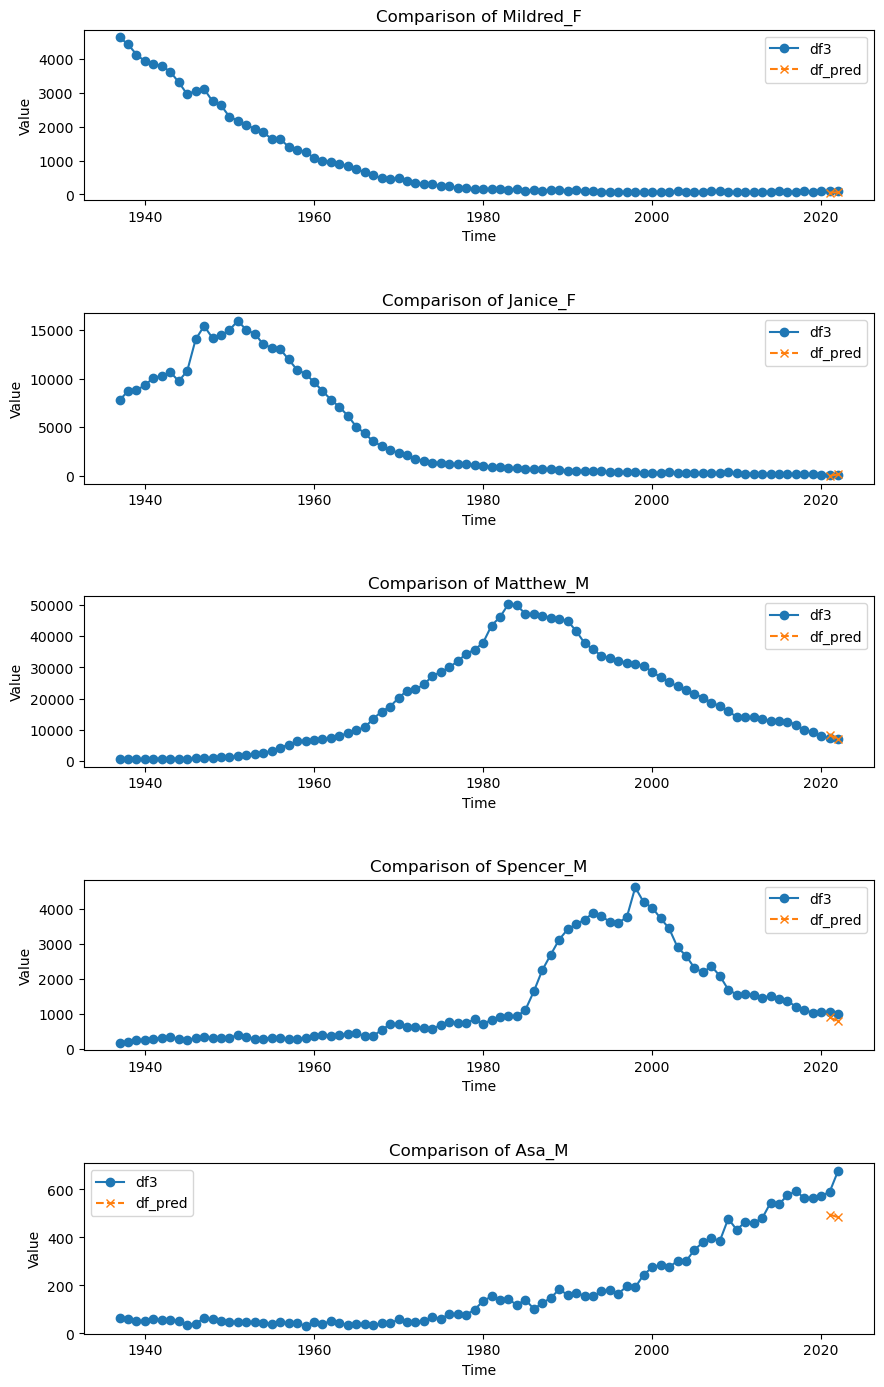

In [23]:
# plot some
num_to_plot = 5
np.random.seed(42)
columns_to_plot = np.random.choice(df3.columns, size=5, replace=False)
fig, axes = plt.subplots(nrows=num_to_plot, ncols=1, figsize=(10, 15))
fig.tight_layout(pad=6.0)
for i, col in enumerate(columns_to_plot):
    axes[i].plot(df3.index, df3[col], label='df3', marker='o', linestyle='-')
    axes[i].plot(df_pred.index, df_pred[col], label='df_pred', marker='x', linestyle='--')
    
    axes[i].set_title(f'Comparison of {col}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Value')
    axes[i].legend()

plt.show()


### zoom-in to recent years for another view of predictions

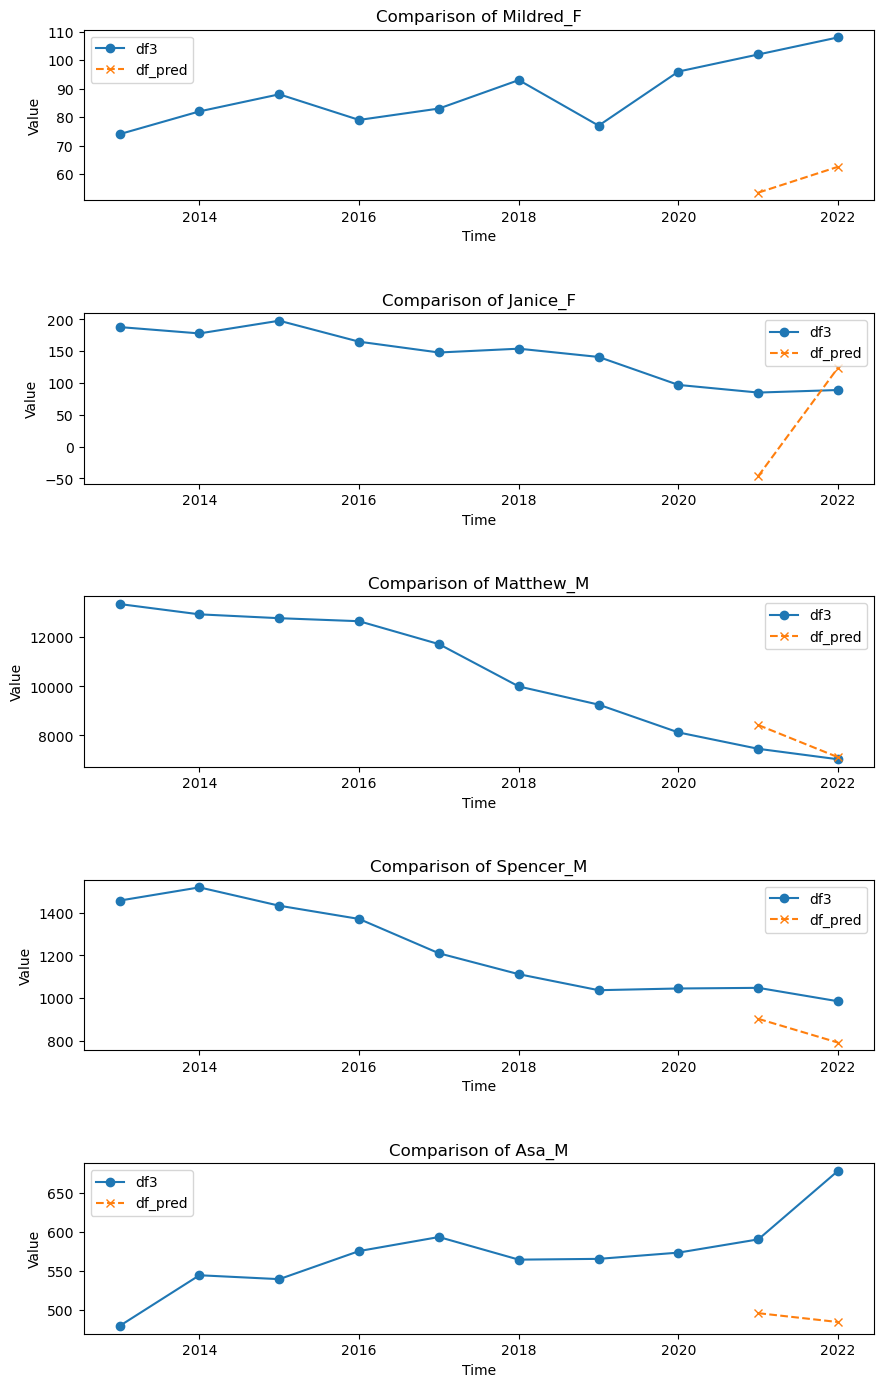

In [24]:
num_years_to_show = 10
num_to_plot = 5
np.random.seed(42)
columns_to_plot = np.random.choice(df3.columns, size=5, replace=False)
fig, axes = plt.subplots(nrows=num_to_plot, ncols=1, figsize=(10, 15))
fig.tight_layout(pad=6.0)
for i, col in enumerate(columns_to_plot):
    axes[i].plot(df3.index[-num_years_to_show:], df3[col].tail(num_years_to_show), label='df3', marker='o', linestyle='-')
    axes[i].plot(df_pred.index, df_pred[col], label='df_pred', marker='x', linestyle='--')
    
    axes[i].set_title(f'Comparison of {col}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Value')
    axes[i].legend()

plt.show()
